In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 111s 513ms/step - accuracy: 0.6681 - loss: 0.6269 - val_accuracy: 0.8435 - val_loss: 0.3911 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 91s 485ms/step - accuracy: 0.8543 - loss: 0.3578 - val_accuracy: 0.8385 - val_loss: 0.3710 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 90s 481ms/step - accuracy: 0.8787 - loss: 0.3169 - val_accuracy: 0.8395 - val_loss: 0.3644 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 88s 469ms/step - accuracy: 0.8831 - loss: 0.2937 - val_accuracy: 0.8305 - val_loss: 0.3822 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 86s 461ms/step - accuracy: 0.8821 - loss: 0.3037 - val_accuracy: 0.7885 - val_loss: 0.4757 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 78s 417ms/step - accuracy: 0.8899 - loss: 0.2956 - val_acc

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

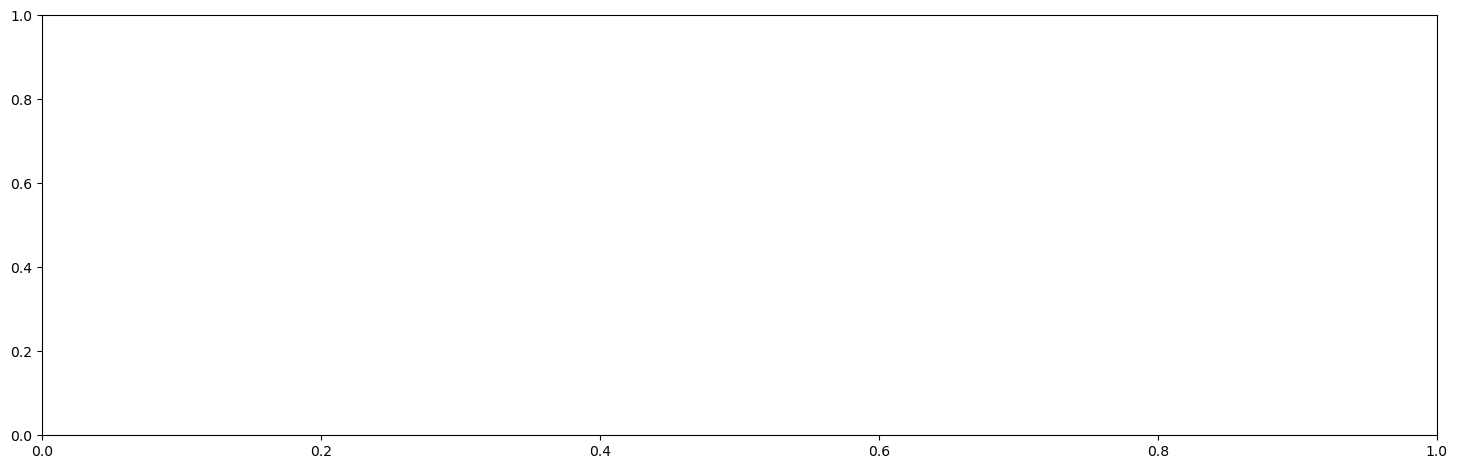

In [6]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Paths to the dataset directories
train_dir = r'C:\Users\Kalivemula Rajendra\Desktop\Project 1\datasets\imagenet\train'
val_dir = r'C:\Users\Kalivemula Rajendra\Desktop\Project 1\datasets\imagenet\validation'
test_dir = r'C:\Users\Kalivemula Rajendra\Desktop\Project 1\datasets\imagenet\test'

# Define image data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create train, validation, and test data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(75, 75),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(75, 75),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(75, 75),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Convert DirectoryIterator to tf.data.Dataset and apply prefetch
def generator_to_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_dataset = generator_to_dataset(train_generator)
val_dataset = generator_to_dataset(val_generator)
test_dataset = generator_to_dataset(test_generator)

# Define the model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(75, 75, 3)))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and data augmentation
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stopping],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Save the model
model.save('drowsiness_detection_model1.keras')

# Evaluate the model on the test dataset
test_results = model.evaluate(test_dataset, steps=len(test_generator))
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')